### Requirements and questions ###

**Exploratory Analysis**
<ul>
<li>Are there any correlation between features? why or why not? </li>
<li>Are there any outliers in the dataset? why or why not? </li>
<li>Are there any normalization needed? why or why not?</li>
<li>Are there any missing values? Why or why not?</li>
</ul>

**Classification**
<ul>
<li>Expriment the following algorithms/models: decision tree, random forest, adaboost, KNN, SVM, MLP, and Naive Baye</li>
<Li>For each model, train-test-split with 80% for training and 20% for testing.</li>
<li>For each algorithm, output the following performance meaures: accuracy, precision, and recall</li>
</ul>

**Visualization**
<ul>
<li>Pick at least one visualization for model perfomance comparison.
</ul>

**Reflection**
<ul>
<li>What is the best K in KNN? Only consider k in the range of 1-15. Use odd numbers only.</li>
<li>What is the most important features found by decision tree and random forest? (optional)</li>
<li>Which algorithm has the highest accuracy? Is there a model overfitting for this algorithm? Why or why not?Perform 10-fold cross-validation with this algorithm and report the accuracy, precision and recall. </li>
</ul>

In [98]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pydotplus

from sklearn import tree, ensemble, linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from IPython.display import Image

In [99]:
# Import Iris Dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
iris = fetch_ucirepo(id=53)
  
# data (as pandas dataframes) 
DataFeatures = iris.data.features 
DataTargets = iris.data.targets

# create Pandas dataframe of merged data, iris is not a DataFrame
iris_merged_df = pd.merge(DataFeatures,DataTargets, right_index=True, left_index=True)

### Exploratory Analysis

Will take a look at the data, pull up statistical analysis and see if there is anything missing or null. Looking at the range of the dataset can determine if normalization is needed. 

In [100]:
iris_merged_df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


I will use label encoder on the classes.

In [101]:
# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit and transform the Gender column
DataTargets_le = pd.DataFrame(le.fit_transform(DataTargets['class']))

In [102]:
iris_merged_df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Normalization is not needed as the ranges are relatively the same (between 0 and 8) with means all between 1 and 6.  

In [103]:
print('Number of missing values by column:')
print(iris_merged_df.isna().sum())

print("\nTotal number of missing values = %d" % (iris_merged_df.isna().sum().sum()))

print('\nNumber of instances = %d' % (iris_merged_df.shape[0]))
print('Number of attributes = %d' % (iris_merged_df.shape[1]))

Number of missing values by column:
sepal length    0
sepal width     0
petal length    0
petal width     0
class           0
dtype: int64

Total number of missing values = 0

Number of instances = 150
Number of attributes = 5


There are no null or missing data.  Next, a quick visualization of the data to look at any correlations. 

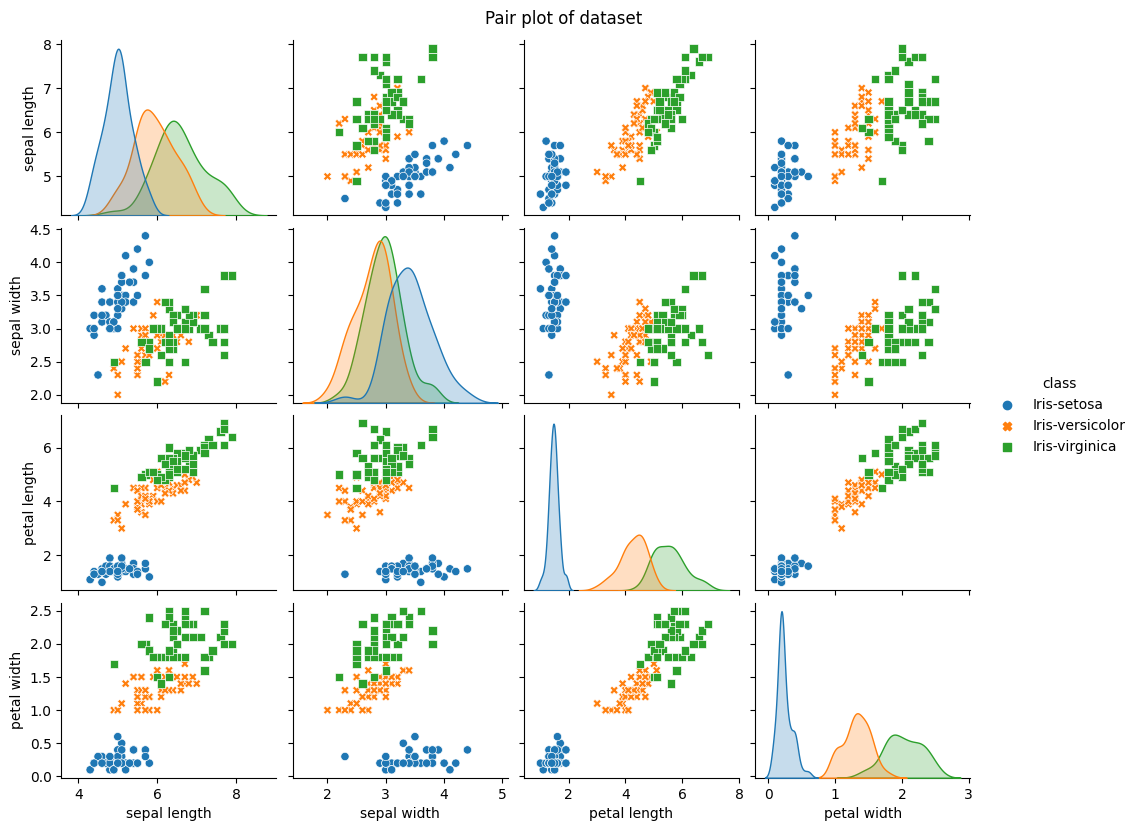

In [104]:
# Visualize entire dataset using Seaborn
# Surpress warnings to free up physical space on printed assignment, source: (https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    g = sns.pairplot(iris_merged_df, hue='class', markers=['o','X','s'])
    g.fig.set_figheight(8)
    g.fig.suptitle('Pair plot of dataset', y=1.02)

In [105]:
correlation_iris_merged_df = iris_merged_df.corr(numeric_only=True)
correlation_iris_merged_df

,sepal length,sepal width,petal length,petal width
sepal length,1.000000,-0.109369,0.871754,0.817954
sepal width,-0.109369,1.000000,-0.420516,-0.356544
petal length,0.871754,-0.420516,1.000000,0.962757
petal width,0.817954,-0.356544,0.962757,1.000000


There is a strong correlation between petal width and petal length with a value of 0.962757.  Petal length and sepal length are slightly correlated at 0.871754.  Other items are not strongly or slightly correlated. Next, it needs to be determined if outliers exist. A boxplot will first be used to visually check.  

<Axes: >

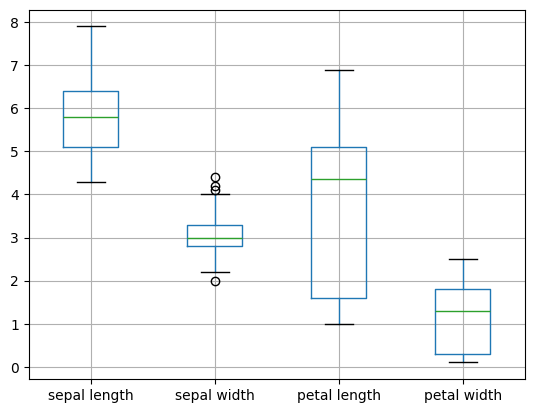

In [106]:
DataFeatures.boxplot()

Boxplot indicates that outliers exist in the sepal width data.  A Z-score can be used to quantify the outlier.  I will use the Z-score and remove the outliers.

In [107]:
Z = (DataFeatures-DataFeatures.mean()) / DataFeatures.std()
Z[(Z.values > 3) | (Z.values < -3)] 

,sepal length,sepal width,petal length,petal width
15,-0.173094,3.104284,-1.280118,-1.046525


There is one value that has a Z score above 3 or below -3, this will be removed. A new pandas dataframe will need to be created with the removed outliers.

In [108]:
print('Number of rows before discarding outliers = %d' % (DataFeatures.shape[0]))
DataFeatures_pp = DataFeatures.drop(15, axis=0)
DataTargets_p = DataTargets_le.drop(15, axis=0)
print('Number of rows after discarding missing values = %d' % (DataFeatures_pp.shape[0]))

# Needed to convert to right shape
DataTargets_pp = np.ravel(DataTargets_p)

Number of rows before discarding outliers = 150
Number of rows after discarding missing values = 149


Confirmed that outliers are removed.  

### Classification / Visualization

##### Decision Tree

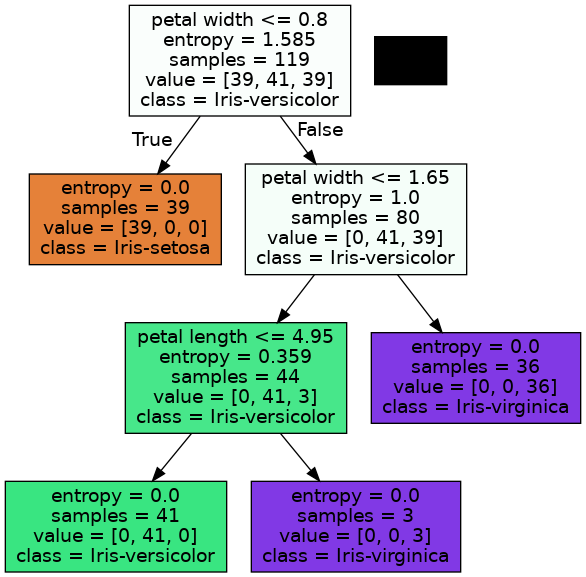

In [109]:
# First create the training and testing data
DataFeatures_train, DataFeatures_test, DataTargets_train, DataTargets_test = train_test_split(DataFeatures_pp,DataTargets_pp, test_size=0.2, train_size=0.8, random_state=42)

# Create decision tree based off of training set
hwt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
hwt = hwt.fit(DataFeatures_train, DataTargets_train)

# Print off decision tree made with training set 
dot_data = tree.export_graphviz(hwt, feature_names=DataFeatures.columns, class_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], filled=True, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))


In [110]:
# Now lets see how accurate the decision tree is against the test data
predDataTargets = hwt.predict(DataFeatures_test)
print('Accuracy on test data is %.9f' % (accuracy_score(DataTargets_test, predDataTargets)))
print('Precision on test data is %.9f' % (precision_score(DataTargets_test, predDataTargets, average='micro')))
print('Recall on test data is %.9f' % recall_score(DataTargets_test, predDataTargets, average='micro'))


Accuracy on test data is 0.900000000
Precision on test data is 0.900000000
Recall on test data is 0.900000000


##### Random Forest

In [111]:
numBaseClassifiers = 100
maxdepth = 10
trainAcc = []
testAcc = []

rfc = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
rfc.fit(DataFeatures_train, DataTargets_train)
target_pred_train = rfc.predict(DataFeatures_train)
target_pred_test = rfc.predict(DataFeatures_test)


# trainAcc.append(accuracy_score(DataFeatures_train, target_pred_train))
# testAcc.append(accuracy_score(DataFeatures_test, DataTargets_test))
print('Precision on test data is %.9f' % (precision_score(DataTargets_test, target_pred_test, average='micro')))
print('Recall on test data is %.9f' % recall_score(DataTargets_test, target_pred_test, average='micro'))

Precision on test data is 0.900000000
Recall on test data is 0.900000000


I could not get accuracy score to work with Random Forest, I kept getting an Value error code 

##### adaboost

In [112]:
clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(DataFeatures_train, DataTargets_train)
Y_predTrain = clf.predict(DataFeatures_train)
Y_predTest = clf.predict(DataFeatures_test)
trainAcc.append(accuracy_score(DataTargets_train, Y_predTrain))
testAcc.append(accuracy_score(DataTargets_test, Y_predTest))
print('Accuracy on test data is %.9f' % accuracy_score(DataTargets_test, Y_predTest))
print('Precision on test data is %.9f' % (precision_score(DataTargets_test, Y_predTest, average='micro')))
print('Recall on test data is %.9f' % recall_score(DataTargets_test, Y_predTest, average='micro'))

Accuracy on test data is 0.900000000
Precision on test data is 0.900000000
Recall on test data is 0.900000000


##### K-Nearest Neighbors

0.9915966386554622
0.9333333333333333
Accuracy on test data is 0.966666667
Precision on test data is 0.966666667
Recall on test data is 0.966666667


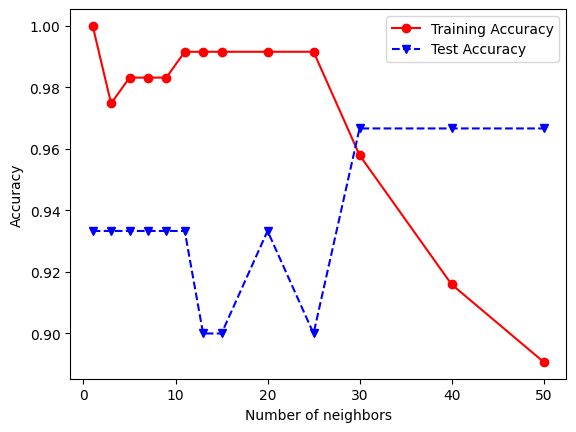

In [113]:
numNeighbors = [1, 3, 5, 7, 9, 11, 13, 15, 20, 25, 30, 40, 50]
trainAcc = []
testAcc = []

for k in numNeighbors:
    knnclf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    knnclf.fit(DataFeatures_train, DataTargets_train)
    knnY_predTrain = knnclf.predict(DataFeatures_train)
    knnY_predTest = knnclf.predict(DataFeatures_test)
    trainAcc.append(accuracy_score(DataTargets_train, knnY_predTrain))
    testAcc.append(accuracy_score(DataTargets_test, knnY_predTest))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
print(trainAcc[5])
print(testAcc[5])
print('Accuracy on test data is %.9f' % accuracy_score(DataTargets_test, knnY_predTest))
print('Precision on test data is %.9f' % (precision_score(DataTargets_test, knnY_predTest, average='micro')))
print('Recall on test data is %.9f' % recall_score(DataTargets_test, knnY_predTest, average='micro'))


##### Support Vector Machine

Accuracy on test data is 0.900000000
Precision on test data is 0.900000000
Recall on test data is 0.900000000


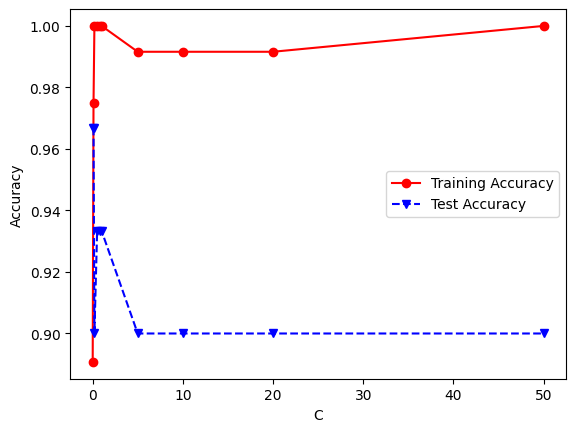

In [114]:
C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
LRtrainAcc = []
LRtestAcc = []
SVMtrainAcc = []
SVMtestAcc = []

for param in C:

    clf = SVC(C=param,kernel='linear')
    clf.fit(DataFeatures_train, DataTargets_train)
    Y_predTrain = clf.predict(DataFeatures_train)
    Y_predTest = clf.predict(DataFeatures_test)
    SVMtrainAcc.append(accuracy_score(DataTargets_train, Y_predTrain))
    SVMtestAcc.append(accuracy_score(DataTargets_test, Y_predTest))

plt.plot(C, SVMtrainAcc, 'ro-', C, SVMtestAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('C')
plt.ylabel('Accuracy')
print('Accuracy on test data is %.9f' % accuracy_score(DataTargets_test, Y_predTest))
print('Precision on test data is %.9f' % (precision_score(DataTargets_test, Y_predTest, average='micro')))
print('Recall on test data is %.9f' % recall_score(DataTargets_test, Y_predTest, average='micro'))



##### Multi-Layer Perceptron

In [115]:
mlpf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlpf.fit(DataFeatures_train, DataTargets_train)
Y_predTrain = mlpf.predict(DataFeatures_train)
Y_predTest = mlpf.predict(DataFeatures_test)

print('Accuracy on test data is %.9f' % (accuracy_score(DataTargets_test, Y_predTest)))
print('Precision on test data is %.9f' % (precision_score(DataTargets_test, Y_predTest, average='micro')))
print('Recall on test data is %.9f' % recall_score(DataTargets_test, Y_predTest, average='micro'))

Accuracy on test data is 0.300000000
Precision on test data is 0.300000000
Recall on test data is 0.300000000


##### Naive Baye

In [116]:
gnb = GaussianNB()
gnb.fit(DataFeatures_train, DataTargets_train)
Y_predTrain = gnb.predict(DataFeatures_train)
Y_predTest = gnb.predict(DataFeatures_test)

print('Accuracy on test data is %.9f' % accuracy_score(DataTargets_test, Y_predTest))
print('Precision on test data is %.9f' % (precision_score(DataTargets_test, Y_predTest, average='micro')))
print('Recall on test data is %.9f' % recall_score(DataTargets_test, Y_predTest, average='micro'))

Accuracy on test data is 0.866666667
Precision on test data is 0.866666667
Recall on test data is 0.866666667


### Reflection

Out of all K in the K-Nearest neighbors from 1-15 (only odd), the best K was 11 with a train accuracy of 0.9915966386554622 and a test accuracy of 0.9333333333333333

Out of all the methods, K-nearest neighbors had the highest accuracy at 0.967.  There doesn't seem to be any overfitting as the test accuracy is increased and maintained at 0.967, while the training accuracy decreases as K increases.

In [117]:
cross_val_score(knnclf, DataFeatures_pp, DataTargets_pp, cv=10, scoring='accuracy')
# cross_val_score(knnclf, DataFeatures_pp, DataTargets_pp, cv=10, scoring='precision')
# cross_val_score(knnclf, DataFeatures_pp, DataTargets_pp, cv=10, scoring='recall')


array([0.86666667, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.86666667, 0.93333333, 0.93333333, 1.        , 0.92857143])

I am not able to display the precision or recall because I performd label encoding on the targets.  I did not have time to go back and change this. 